In [1]:
import matplotlib.pyplot as plt
from tabulate import tabulate
from numpy import load
import numpy as np
from numpy.random import seed
from numpy.random import shuffle
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter,extrema
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage import zoom
from scipy.spatial.distance import pdist
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib as mpl

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.path import Path
from matplotlib.collections import LineCollection
from sklearn.decomposition import PCA
from scipy.stats import entropy

/public/apps/python/3.7.0/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Human P1

In [2]:
p1_rg=pd.read_csv("p1_rg.csv")
p1_secstruc=pd.read_csv("p1_secstruct.csv")
#p1_hbond=pd.read_csv("p1_hbond.csv")
#p1_energy=pd.read_csv("p1_energy.csv")
frame_counts=p1_secstruc.groupby('sim').Frames.max()
for simm in frame_counts.index:
    secstruc_bool=(p1_secstruc.sim==simm) & (p1_secstruc.Frames==frame_counts[simm]) 
    p1_secstruc=p1_secstruc[~secstruc_bool]
temp_secstruc=p1_secstruc.Secstruct.values
temp_secstruc=temp_secstruc.reshape((int(temp_secstruc.shape[0]/50)),50)
temp_secstruc=pd.DataFrame(data=temp_secstruc,columns=p1_secstruc.Residues.unique())
p1_secstruc=pd.concat([p1_rg.iloc[:,:2],temp_secstruc],axis=1)
del temp_secstruc
p1_rg=p1_rg[p1_rg.sim!=15]
p1_rg=p1_rg[p1_rg.sim!=13]
p1_secstruc=p1_secstruc[p1_secstruc.sim!=15]
p1_secstruc=p1_secstruc[p1_secstruc.sim!=13]


In [3]:
def ss_propensity(df_secstruc):
    temp_secstruc=df_secstruc.iloc[:,2:]
    ss_tot=temp_secstruc.shape[1]
    ss=temp_secstruc.ne(0).sum(axis=1)
    ss_frac=ss/ss_tot
    return ss_frac

In [ ]:
#this removes un-equilibrated frames
# blank_df = pd.DataFrame()
# for sim in p1_rg.sim.unique():
#     temp_df = p1_rg[p1_rg.sim==sim].iloc[-40000:,:]
#     blank_df = blank_df.append(temp_df)
# p1_rg = blank_df.copy()

# blank_df = pd.DataFrame()
# for sim in p1_secstruc.sim.unique():
#     temp_df = p1_secstruc[p1_secstruc.sim==sim].iloc[-40000:,:]
#     blank_df = blank_df.append(temp_df)
# p1_secstruc = blank_df.copy()

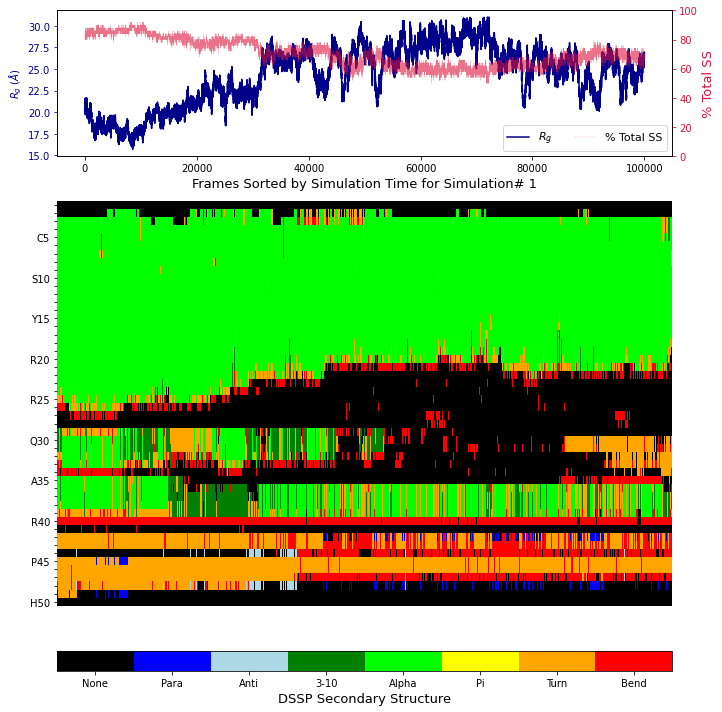

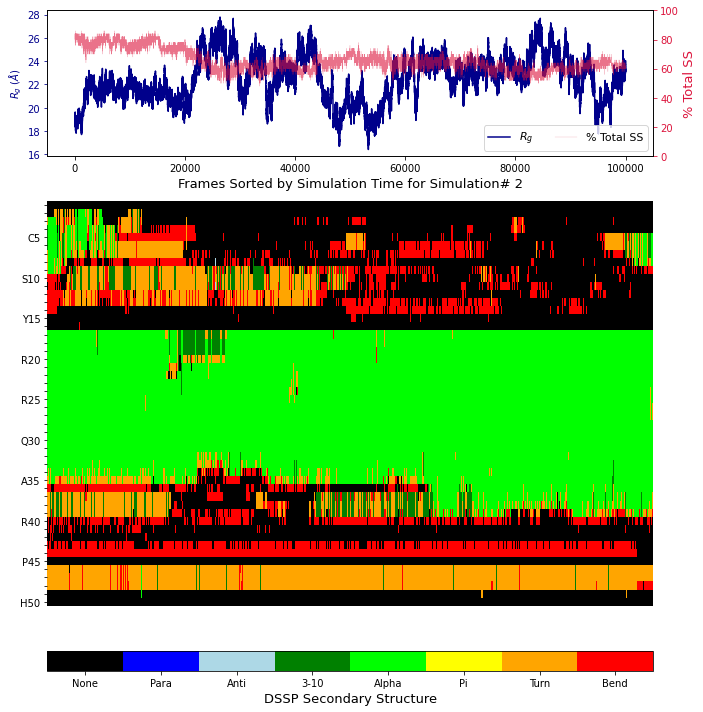

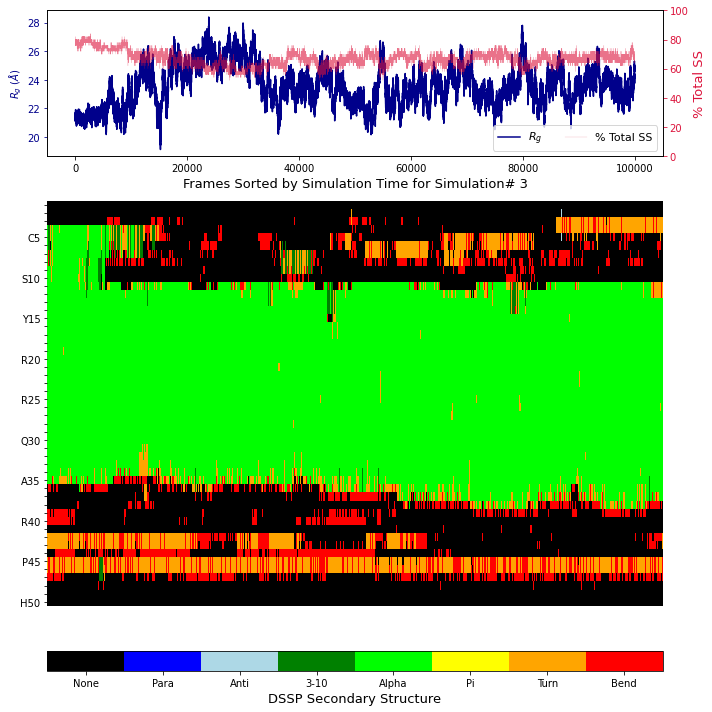

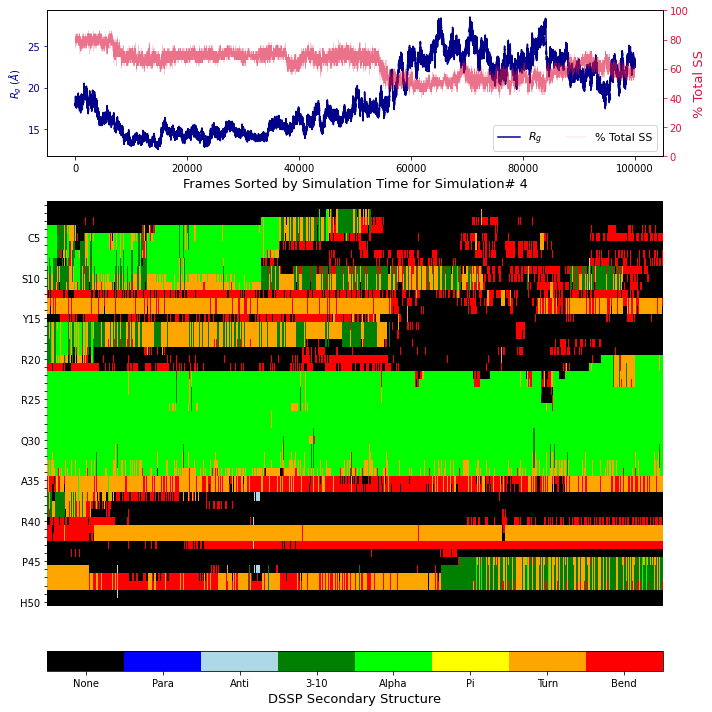

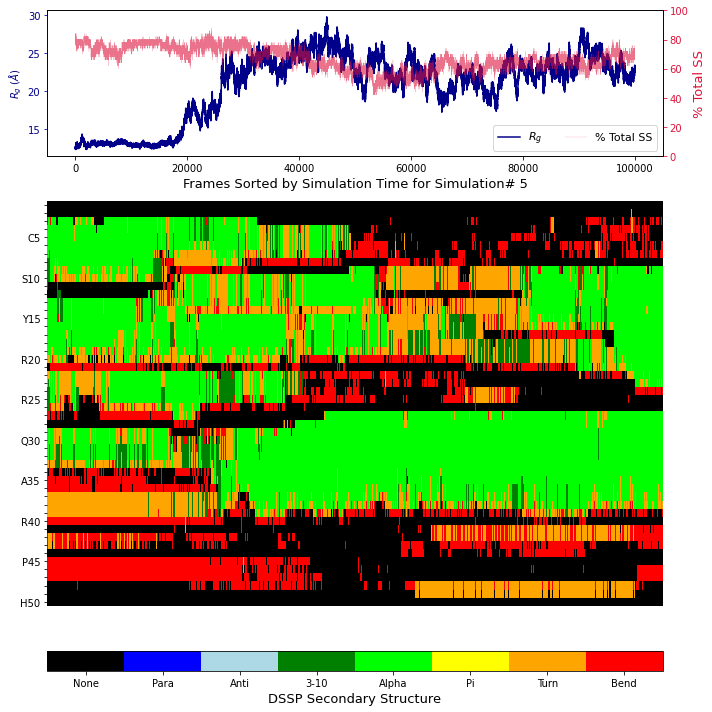

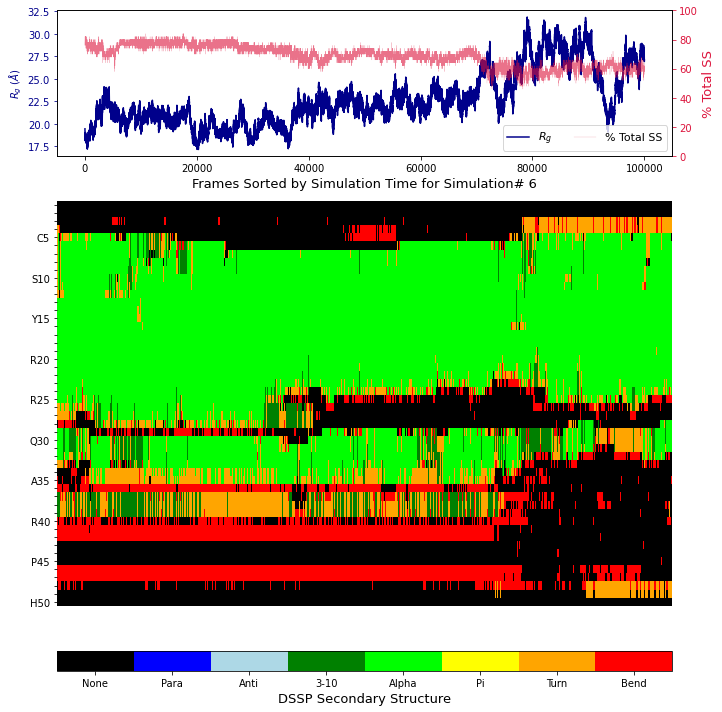

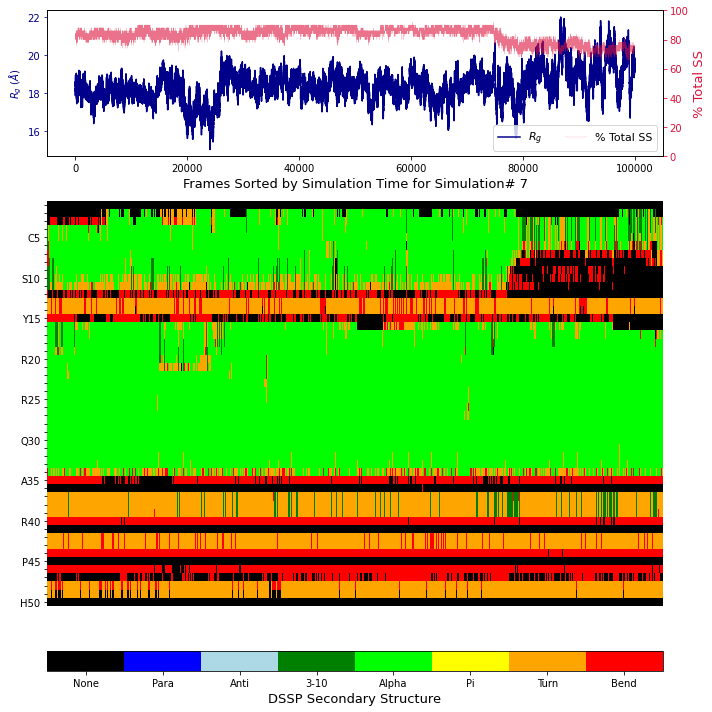

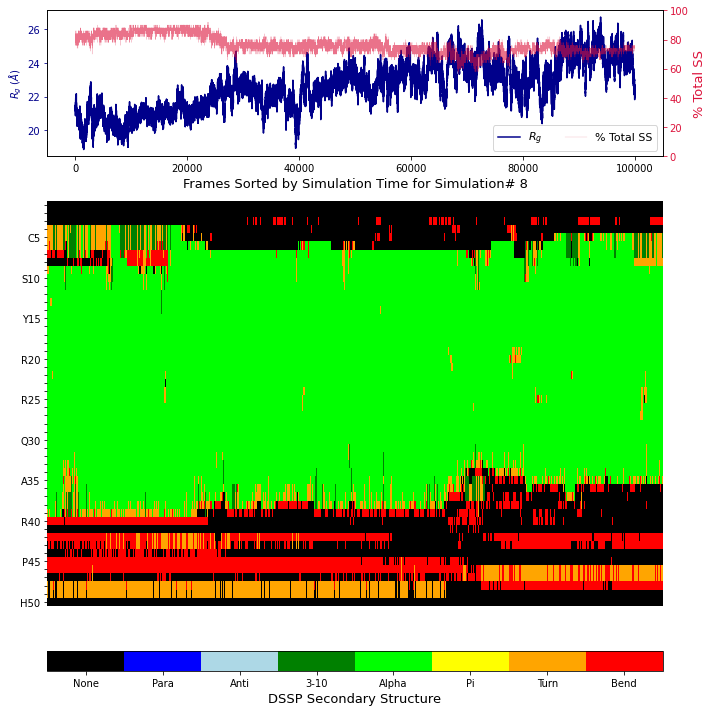

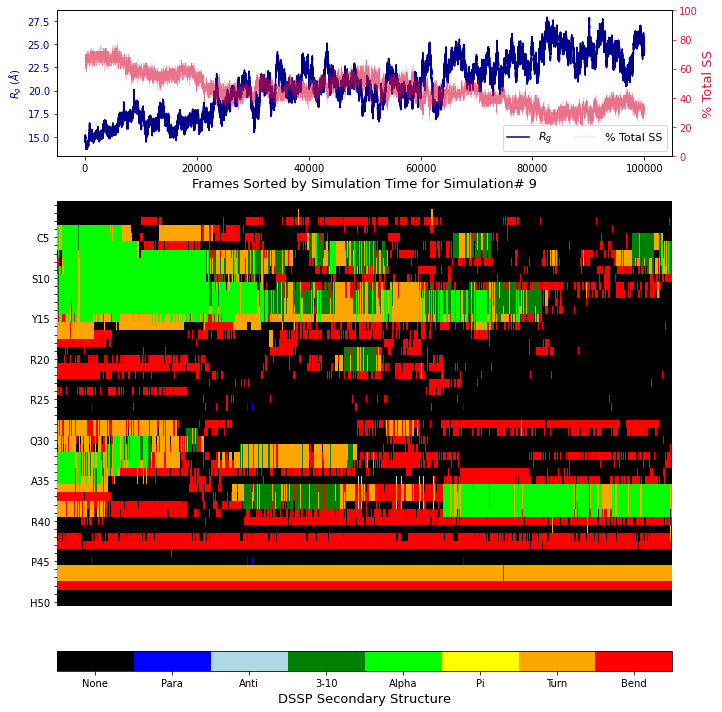

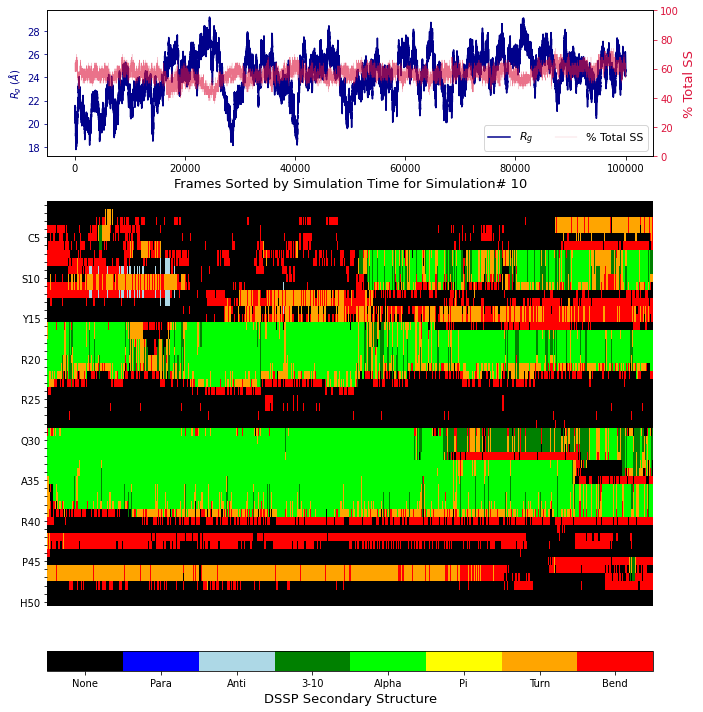

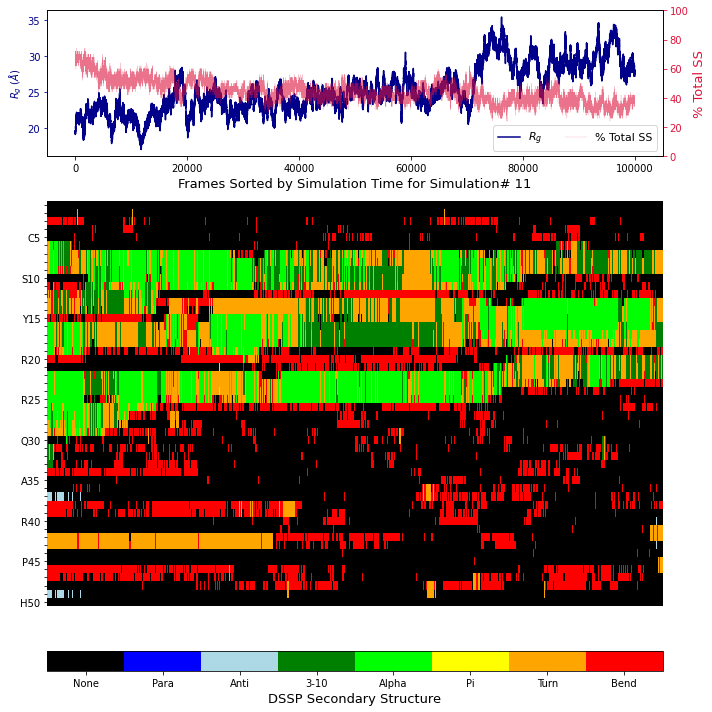

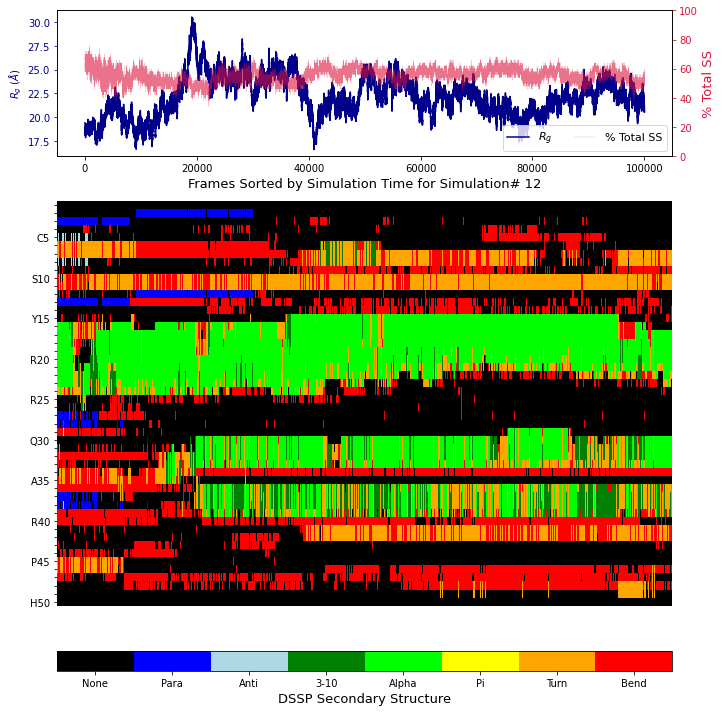

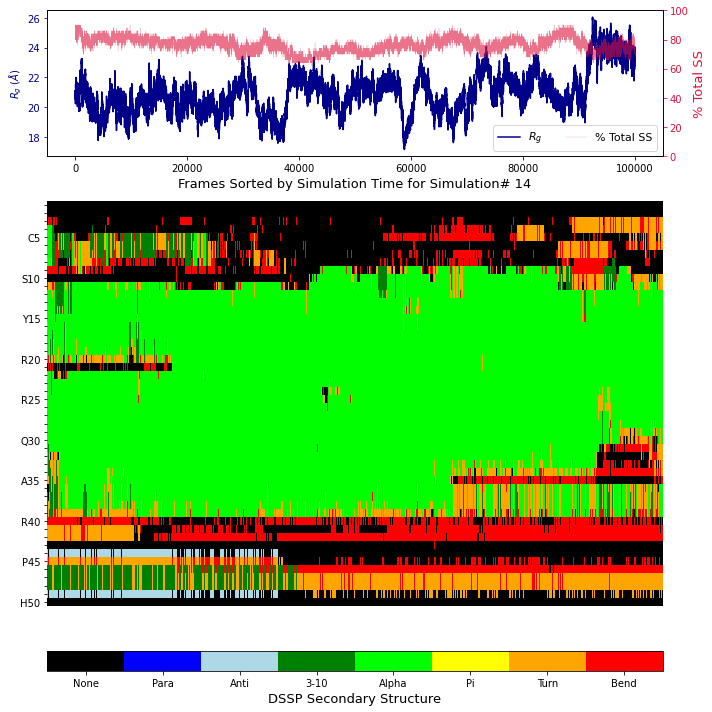

In [21]:
#'width_ratios': [15],
#WATCH out make sure to add the right number of simulations
sims= [1,2,3,4,5,6,7,8,9,10,11,12,14]
for sim in sims:
    fig,axs=plt.subplots(ncols=1,nrows=3,figsize=(10,10),
                         gridspec_kw={'height_ratios':[1.8,5,0.25]})
    p1_heatmap=p1_secstruc[p1_secstruc.sim==sim].copy()
    ss=ss_propensity(p1_secstruc[p1_secstruc.sim==sim])
    p1_heatmap['Rg']=p1_rg[p1_rg.sim==sim].Rg.values
    p1_heatmap['total_ss']=ss.values
    #p1_heatmap=p1_heatmap.sort_values(by=['Rg'],ascending=True)
    rg_line=axs[0].plot(p1_heatmap.frames.values,p1_heatmap.Rg.values, color='darkblue',linewidth=1.5,label=r'$R_{g}$')
    #axs[0].legend(fontsize=10,loc='lower right')
    axs[0].set_ylabel(r'$R_{g}$'+' ('+r'$\AA$'+')',color='darkblue')
    axs[0].tick_params(axis="y", colors="darkblue")
    axs[0].tick_params(axis="x", bottom=True, labelbottom=True,labelsize=10)
    plt.setp(axs[0].get_yticklabels(), fontsize=10)
    axs[0].set_xlabel('Frames Sorted by Simulation Time for Simulation# '+str(sim),
                       fontsize=13)

    #axs[0].set_title('Human P1 Protamine: All Simulations Combined',
    #                   fontsize=20)
    ax=axs[0].twinx()
    total_ss_line=ax.plot(p1_heatmap.total_ss.values*100,color='crimson',alpha=0.6,
                          linewidth=0.2,label='% Total SS')
    ax.set_ylabel('% Total SS', color='crimson',fontsize=13)
    plt.setp(ax.get_yticklabels(), fontsize=8)
    ax.tick_params(axis="y", colors="crimson",labelsize=10)
    ax.set_ylim(0,100)
    total_lines=rg_line+total_ss_line
    total_labs=[l.get_label() for l in total_lines]
    ax.legend(total_lines,total_labs,fontsize=11,loc='lower right',ncol=2)
    sequence='ARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPRCRRH'
    sequence=[sequence[i-1]+str(i) for i in range(1,len(sequence)+1)]
    sns.heatmap(p1_heatmap.iloc[:,2:-2].T,ax=axs[1],
                xticklabels=False,yticklabels=True,
                cmap=ListedColormap(['black', 'blue','lightblue',
                                     'green','lime','yellow','orange','red']),
                cbar=False)
    axs[1].set_yticklabels(sequence,fontsize=10)
    plt.setp([y_label_seq for y_label_seq in axs[1].get_yticklabels() if y_label_seq not in axs[1].get_yticklabels()[4::5]],
             visible=False)

    cmap = mpl.colors.ListedColormap(['black', 'blue','lightblue',
                                      'green','lime','yellow','orange','red'])
    cmap.set_over('0.25')
    cmap.set_under('0.75')

    bounds = [0, 1, 2, 3, 4, 5,6,7, 8]
    ticks=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    cbar = mpl.colorbar.ColorbarBase(axs[2], cmap=cmap,
                                    norm=norm,
                                    boundaries=bounds,
                                    ticks=ticks,
                                    spacing='proportional',
                                    orientation='horizontal')
    cbar.set_ticklabels(['None','Para','Anti','3-10','Alpha','Pi','Turn','Bend'])
    cbar.set_label('DSSP Secondary Structure',size=13)
    ticklabs = cbar.ax.get_yticklabels()
    cbar.ax.set_yticklabels(ticklabs)
    font_size=10
    cbar.ax.tick_params(labelsize=font_size)
    plt.setp(axs[2].get_yticklabels(), fontsize=10)
    #axs[0,1].remove()
    plt.tight_layout()
    plt.savefig('manuscript_revision/p1_secstruc_sim'+str(sim)+'.png',dpi=400,bbox_inches='tight')


# Salmon

In [6]:
salmon_rg = pd.read_csv("salmon_rg.csv").iloc[:,:3]
salmon_moments = pd.read_csv("salmon_moments.csv")
salmon_rg = pd.concat([salmon_rg,salmon_moments],axis=1)
salmon_ree = pd.read_csv("salmon_ree.csv")
salmon_rg_ree=pd.concat([salmon_rg,salmon_ree['Ree']],axis=1)
salmon_secstruc=pd.read_csv("salmon_secstruct.csv")
salmon_energy=pd.read_csv("salmon_energy.csv")
salmon_hbond=pd.read_csv("salmon_hbond.csv")
frame_counts=salmon_secstruc.groupby('sim').Frames.max()
for simm in frame_counts.index:
    secstruc_bool=(salmon_secstruc.sim==simm) & (salmon_secstruc.Frames==frame_counts[simm]) 
    salmon_secstruc=salmon_secstruc[~secstruc_bool]
temp_secstruc=salmon_secstruc.Secstruct.values
temp_secstruc=temp_secstruc.reshape((int(temp_secstruc.shape[0]/33)),33)
temp_secstruc=pd.DataFrame(data=temp_secstruc,columns=salmon_secstruc.Residues.unique())
salmon_secstruc=pd.concat([salmon_rg.iloc[:,:2],temp_secstruc],axis=1)
del temp_secstruc

In [7]:
salmon_rg=salmon_rg[salmon_rg.sim!=2]
salmon_rg=salmon_rg[salmon_rg.sim!=11]
salmon_rg_ree=salmon_rg_ree[salmon_rg_ree.sim!=2]
salmon_rg_ree=salmon_rg_ree[salmon_rg_ree.sim!=11]
salmon_secstruc=salmon_secstruc[salmon_secstruc.sim!=2]
salmon_secstruc=salmon_secstruc[salmon_secstruc.sim!=11]
salmon_hbond=salmon_hbond[salmon_hbond.sim!=2]
salmon_hbond=salmon_hbond[salmon_hbond.sim!=11]
salmon_energy=salmon_energy[salmon_energy.sim!=2]
salmon_energy=salmon_energy[salmon_energy.sim!=11]
#salmon_omega=salmon_omega[salmon_omega.sim!=2]
#salmon_omega=salmon_omega[salmon_omega.sim!=11]
#salmon=salmon[salmon.sim!=2]
#salmon=salmon[salmon.sim!=11]
#salmon_moments=salmon_moments[salmon_moments.sim!=2]
#salmon_moments=salmon_moments[salmon_moments.sim!=11]

In [8]:
#salmon protamine has more than 200ns for some of the simulations, so this step is to make sure
#..<continued> the extra frames are removed. Salmon, P1,P2a and P2b all have 200ns. Salmon cannot
#..<continued> have more than 200ns (hence removing extra frames beyond 200ns)
temp_df=salmon_rg.copy()
for sim in temp_df.sim.unique():
    n=temp_df[temp_df.sim==sim].frames.max()-100000
    if n>0:
        temp_df.drop(temp_df[temp_df.sim==sim].tail(n).index,inplace=True)
salmon_rg=temp_df.copy()
del temp_df

#temp_df=salmon_total_contact.copy()
#for sim in temp_df.sim.unique():
#salmon_total_contact dataframe has Frames with capital F
#    n=temp_df[temp_df.sim==sim].Frames.max()-100000
#    if n>0:
#        temp_df.drop(temp_df[temp_df.sim==sim].tail(n).index,inplace=True)
#salmon_total_contact=temp_df.copy()
#del temp_df

#temp_df=salmon.copy()
#for sim in temp_df.sim.unique():
#    n=temp_df[temp_df.sim==sim].frames.max()-100000
#    if n>0:
#        temp_df.drop(temp_df[temp_df.sim==sim].tail(n).index,inplace=True)
#del temp_df

temp_df=salmon_hbond.copy()
for sim in temp_df.sim.unique():
#salmon_hbond dataframe has Frames with capital F
    n=temp_df[temp_df.sim==sim].Frames.max()-100000
    if n>0:
        temp_df.drop(temp_df[temp_df.sim==sim].tail(n).index,inplace=True)
salmon_hbond=temp_df.copy()
del temp_df

temp_df=salmon_energy.copy()
for sim in temp_df.sim.unique():
#salmon_energy dataframe has Frames with capital F
    n=temp_df[temp_df.sim==sim].Frames.max()-100000
    if n>0:
        temp_df.drop(temp_df[temp_df.sim==sim].tail(n).index,inplace=True)
salmon_energy=temp_df.copy()
del temp_df

temp_df=salmon_secstruc.copy()
for sim in temp_df.sim.unique():
    n=temp_df[temp_df.sim==sim].frames.max()-100000
    if n>0:
        temp_df.drop(temp_df[temp_df.sim==sim].tail(n).index,inplace=True)
salmon_secstruc=temp_df.copy()
del temp_df

temp_df=salmon_rg_ree.copy()
for sim in temp_df.sim.unique():
    n=temp_df[temp_df.sim==sim].frames.max()-100000
    if n>0:
        temp_df.drop(temp_df[temp_df.sim==sim].tail(n).index,inplace=True)
salmon_rg_ree=temp_df.copy()
del temp_df


In [ ]:
# %%time
# #blank_df = pd.DataFrame()
# #for sim in salmon.sim.unique():
# #    temp_df = salmon[salmon.sim==sim].iloc[-40000:,:]
# #    blank_df = blank_df.append(temp_df)
# #salmon = blank_df.copy()

# blank_df = pd.DataFrame()
# for sim in salmon_rg.sim.unique():
#     temp_df = salmon_rg[salmon_rg.sim==sim].iloc[-40000:,:]
#     blank_df = blank_df.append(temp_df)
# salmon_rg = blank_df.copy()

# blank_df = pd.DataFrame()
# for sim in salmon_secstruc.sim.unique():
#     temp_df = salmon_secstruc[salmon_secstruc.sim==sim].iloc[-40000:,:]
#     blank_df = blank_df.append(temp_df)
# salmon_secstruc = blank_df.copy()

# blank_df = pd.DataFrame()
# for sim in salmon_hbond.sim.unique():
#     temp_df = salmon_hbond[salmon_hbond.sim==sim].iloc[-40000:,:]
#     blank_df = blank_df.append(temp_df)
# salmon_hbond = blank_df.copy()

# #blank_df = pd.DataFrame()
# #for sim in salmon_total_contact.sim.unique():
# #    temp_df = salmon_total_contact[salmon_total_contact.sim==sim].iloc[-40000:,:]
# #    blank_df = blank_df.append(temp_df)
# #salmon_total_contact = blank_df.copy()

# del blank_df
# del temp_df

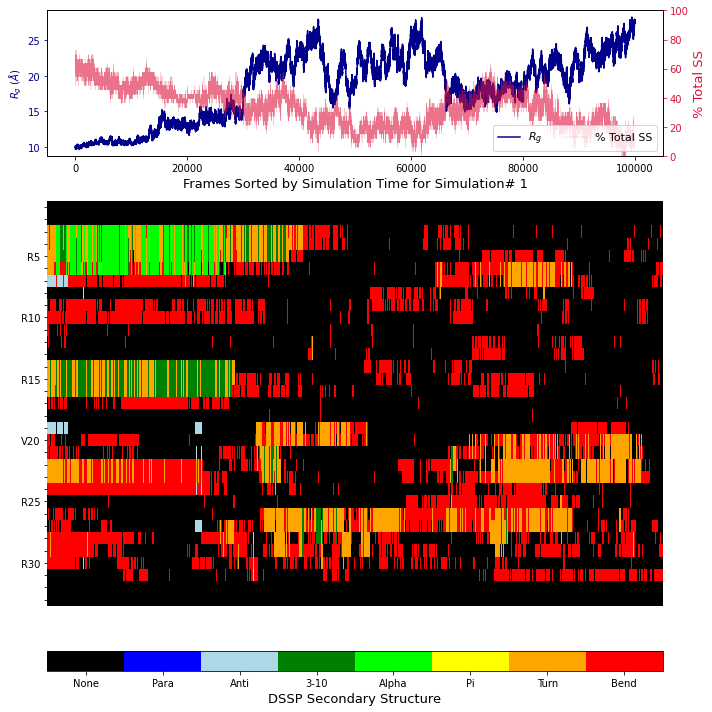

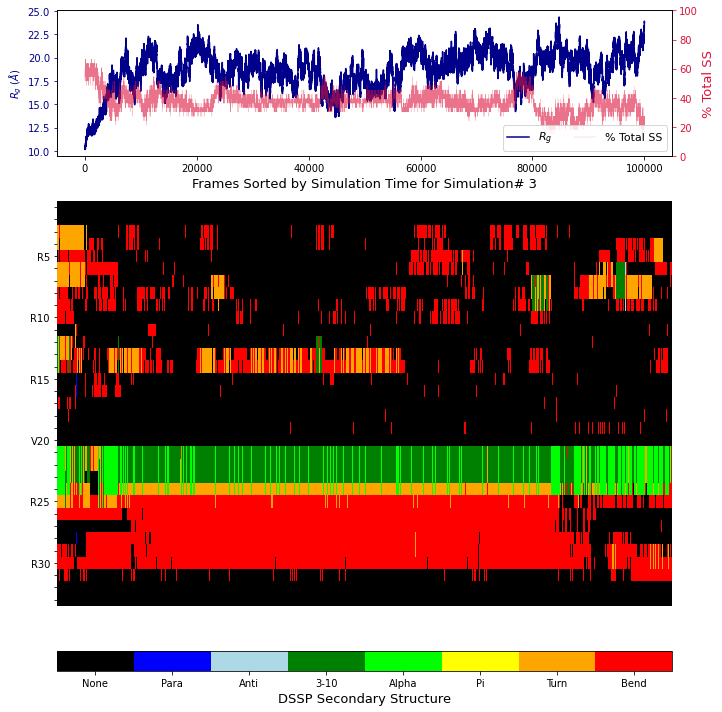

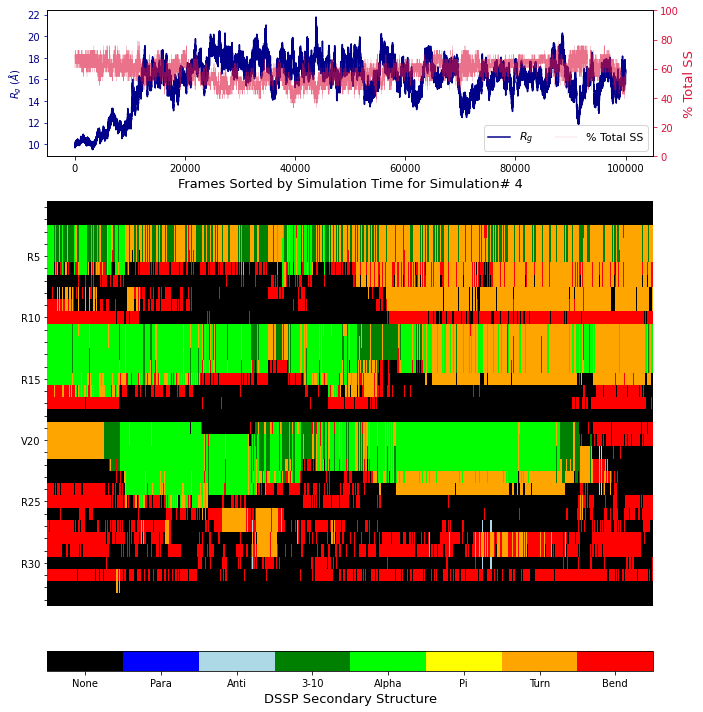

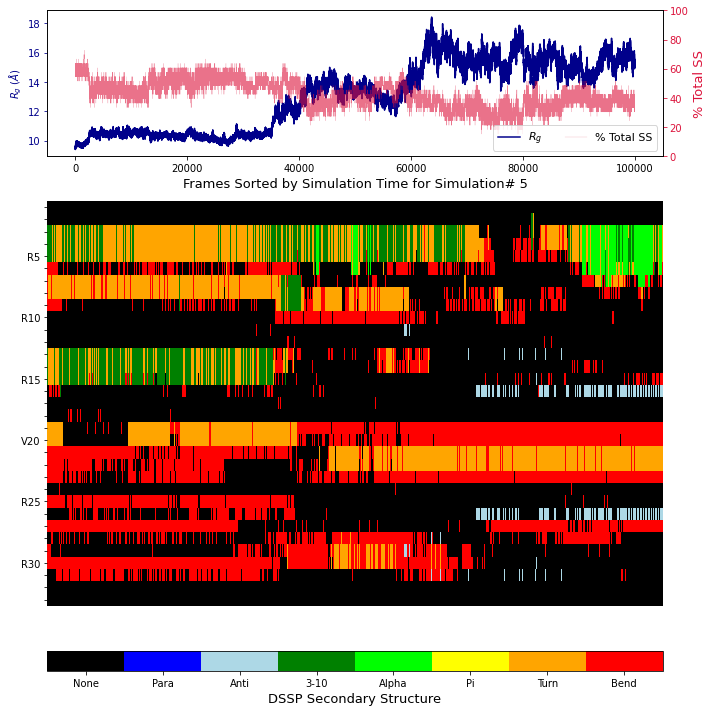

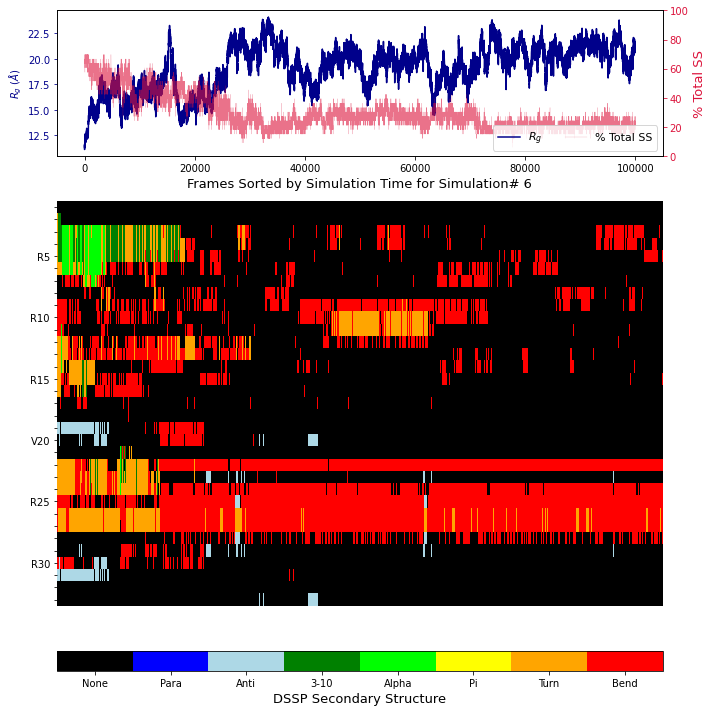

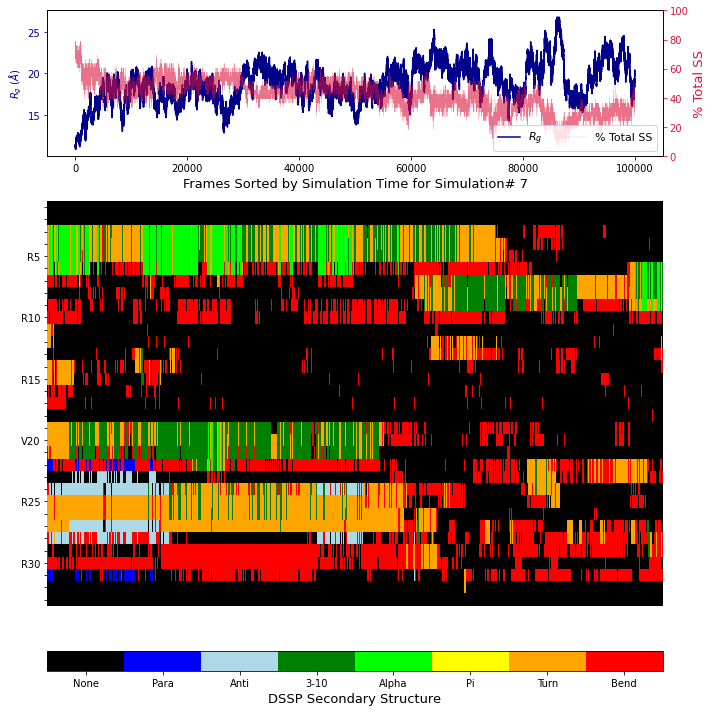

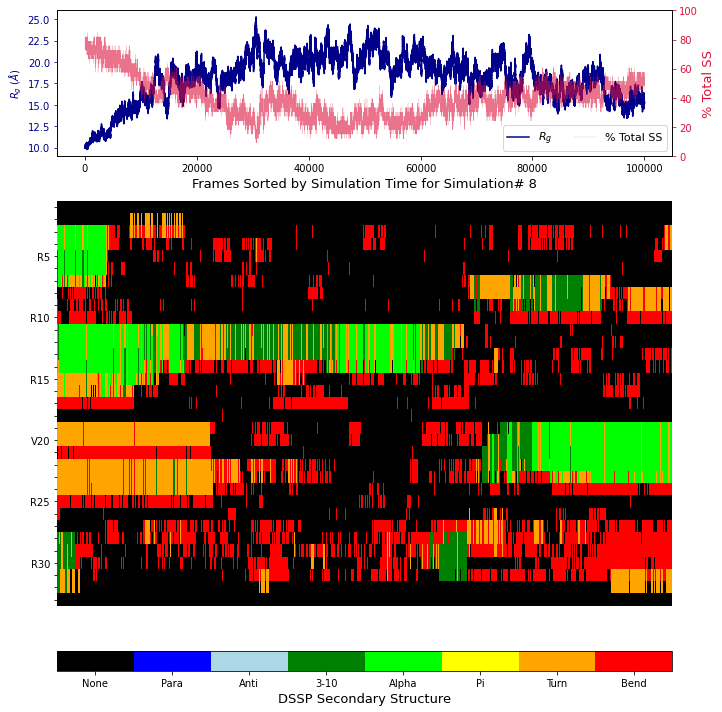

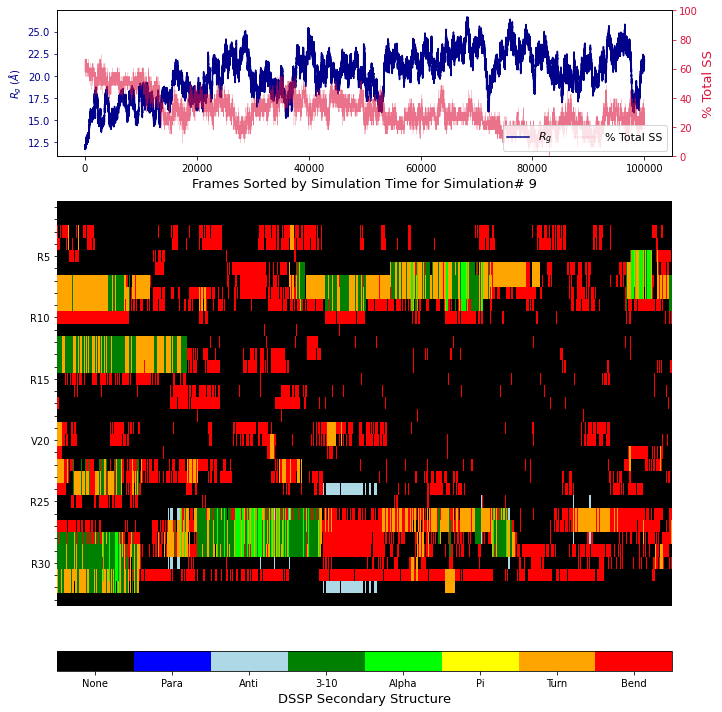

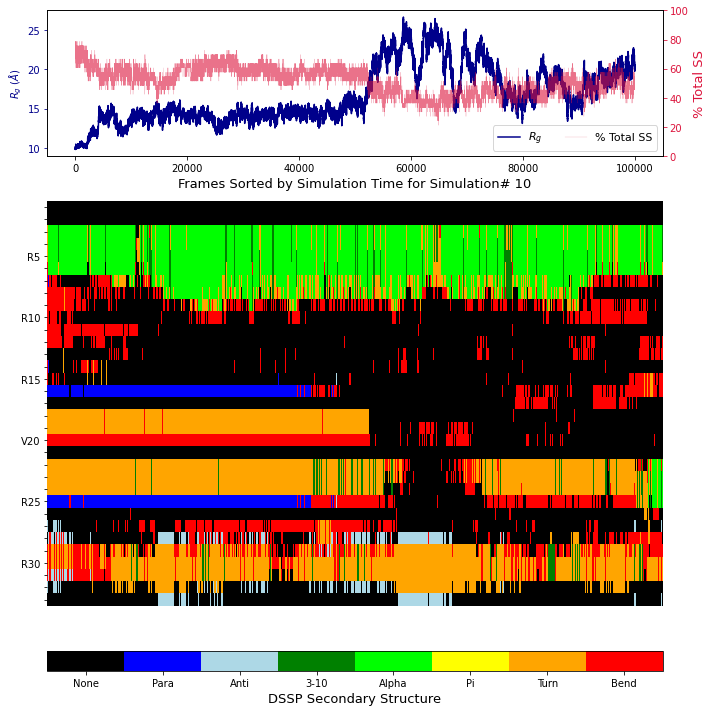

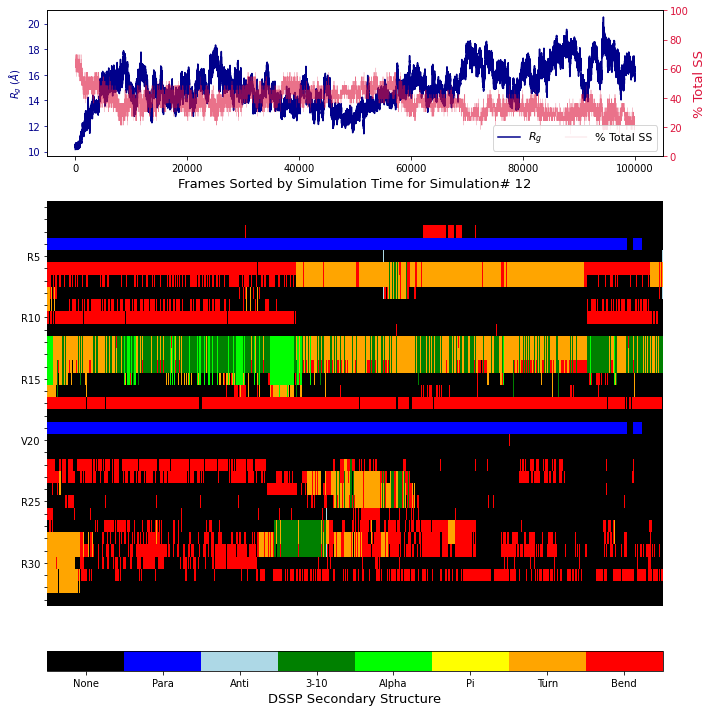

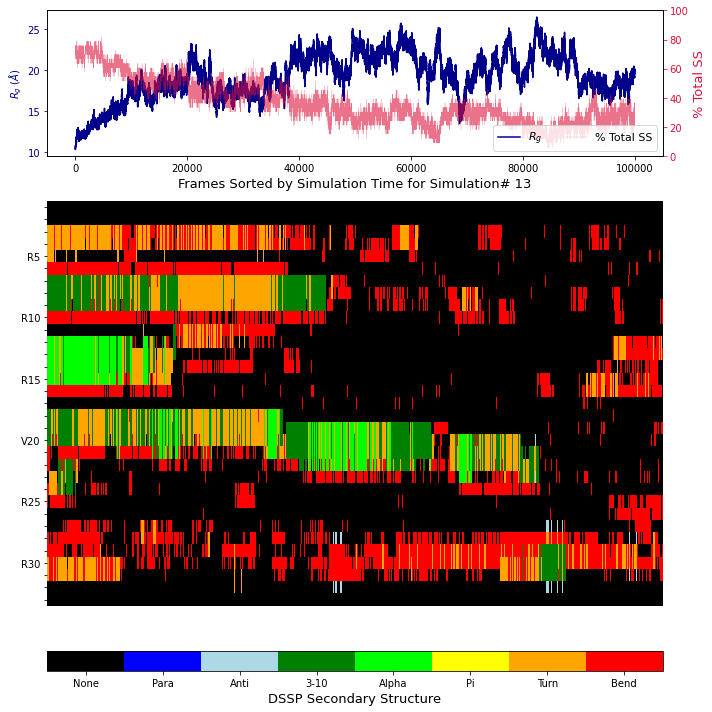

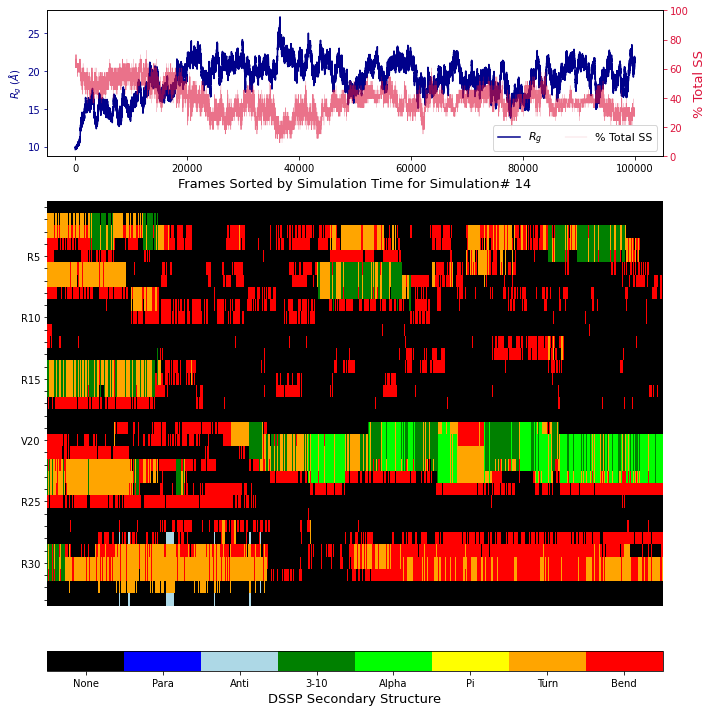

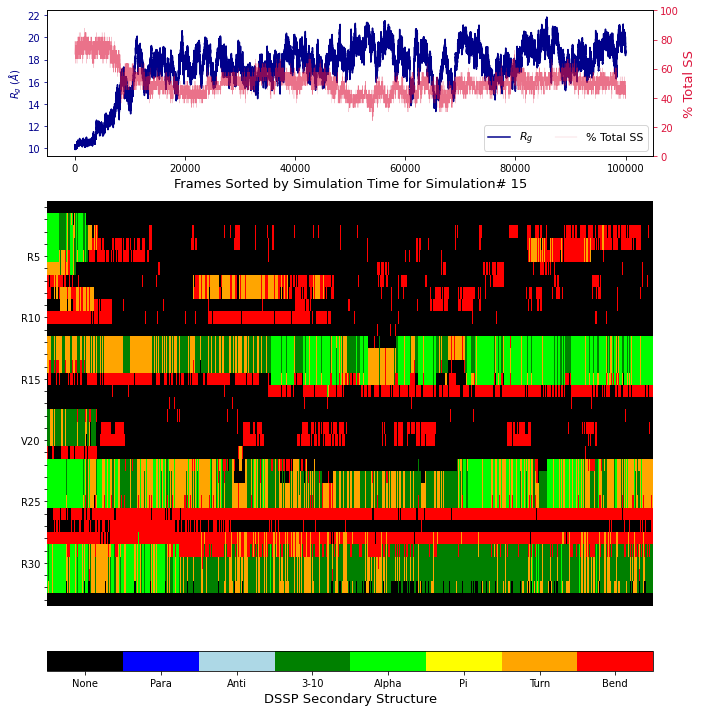

In [35]:
#'width_ratios': [15],
#make sure CORRECT number of sims
sims=[1,3,4,5,6,7,8,9,10,12,13,14,15]
for sim in sims:
    fig,axs=plt.subplots(ncols=1,nrows=3,figsize=(10,10),
                         gridspec_kw={'height_ratios':[1.8,5,0.25]})
    salmon_heatmap=salmon_secstruc[salmon_secstruc.sim==sim].copy()
    ss=ss_propensity(salmon_secstruc[salmon_secstruc.sim==sim])
    salmon_heatmap['Rg']=salmon_rg[salmon_rg.sim==sim].Rg.values
    salmon_heatmap['total_ss']=ss.values
    #salmon_heatmap=salmon_heatmap.sort_values(by=['Rg'],ascending=True)
    rg_line=axs[0].plot(salmon_heatmap.frames.values,salmon_heatmap.Rg.values, color='darkblue',linewidth=1.5,label=r'$R_{g}$')
    #axs[0].legend(fontsize=10,loc='lower right')
    axs[0].set_ylabel(r'$R_{g}$'+' ('+r'$\AA$'+')',color='darkblue')
    axs[0].tick_params(axis="y", colors="darkblue")
    axs[0].tick_params(axis="x", bottom=True, labelbottom=True,labelsize=10)
    plt.setp(axs[0].get_yticklabels(), fontsize=10)
    axs[0].set_xlabel('Frames Sorted by Simulation Time for Simulation# '+str(sim),
                       fontsize=13)

    #axs[0].set_title('Human salmon Protamine: All Simulations Combined',
    #                   fontsize=20)
    ax=axs[0].twinx()
    total_ss_line=ax.plot(salmon_heatmap.total_ss.values*100,color='crimson',alpha=0.6,
                          linewidth=0.2,label='% Total SS')
    ax.set_ylabel('% Total SS', color='crimson',fontsize=13)
    plt.setp(ax.get_yticklabels(), fontsize=8)
    ax.tick_params(axis="y", colors="crimson",labelsize=10)
    ax.set_ylim(0,100)
    total_lines=rg_line+total_ss_line
    total_labs=[l.get_label() for l in total_lines]
    ax.legend(total_lines,total_labs,fontsize=11,loc='lower right',ncol=2)
    sequence='MPRRRRSSSRPVRRRRRPRVSRRRRRRGGRRRR'
    sequence=[sequence[i-1]+str(i) for i in range(1,len(sequence)+1)]
    sns.heatmap(salmon_heatmap.iloc[:,2:-2].T,ax=axs[1],
                xticklabels=False,yticklabels=True,
                cmap=ListedColormap(['black', 'blue','lightblue',
                                     'green','lime','yellow','orange','red']),
                cbar=False)
    axs[1].set_yticklabels(sequence,fontsize=10)
    plt.setp([y_label_seq for y_label_seq in axs[1].get_yticklabels() if y_label_seq not in axs[1].get_yticklabels()[4::5]],
             visible=False)

    cmap = mpl.colors.ListedColormap(['black', 'blue','lightblue',
                                      'green','lime','yellow','orange','red'])
    cmap.set_over('0.25')
    cmap.set_under('0.75')

    bounds = [0, 1, 2, 3, 4, 5,6,7, 8]
    ticks=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    cbar = mpl.colorbar.ColorbarBase(axs[2], cmap=cmap,
                                    norm=norm,
                                    boundaries=bounds,
                                    ticks=ticks,
                                    spacing='proportional',
                                    orientation='horizontal')
    cbar.set_ticklabels(['None','Para','Anti','3-10','Alpha','Pi','Turn','Bend'])
    cbar.set_label('DSSP Secondary Structure',size=13)
    ticklabs = cbar.ax.get_yticklabels()
    cbar.ax.set_yticklabels(ticklabs)
    font_size=10
    cbar.ax.tick_params(labelsize=font_size)
    plt.setp(axs[2].get_yticklabels(), fontsize=10)
    #axs[0,1].remove()
    plt.tight_layout()
    plt.savefig('manuscript_revision/salmon_secstruc_sim'+str(sim)+'.png',dpi=400,bbox_inches='tight')


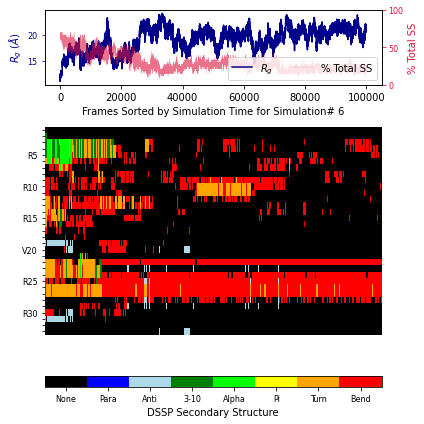

In [9]:
fig,axs=plt.subplots(ncols=1,nrows=3,figsize=(6,6),
                     gridspec_kw={'height_ratios':[1.8,5,0.25]})
#'width_ratios': [15],
sim=6
salmon_heatmap=salmon_secstruc[salmon_secstruc.sim==sim].copy()
ss=ss_propensity(salmon_secstruc[salmon_secstruc.sim==sim])
salmon_heatmap['Rg']=salmon_rg_ree[salmon_rg_ree.sim==sim].Rg.values
salmon_heatmap['Ree']=salmon_rg_ree[salmon_rg_ree.sim==sim].Ree.values
salmon_heatmap['ratio']=salmon_heatmap.Ree.values**2/salmon_heatmap.Rg.values**2
salmon_heatmap['total_ss']=ss.values
#salmon_heatmap=salmon_heatmap.sort_values(by=['Rg'],ascending=True)
rg_line=axs[0].plot(salmon_heatmap.Rg.values, color='darkblue',linewidth=1.5,label=r'$R_{g}$')
#axs[0].legend(fontsize=10,loc='lower right')
axs[0].set_ylabel(r'$R_{g}$'+' ('+r'$\AA$'+')',color='darkblue',fontsize=10)
axs[0].tick_params(axis="y", colors="darkblue")
axs[0].tick_params(axis="x", bottom=True, labelbottom=True)
plt.setp(axs[0].get_yticklabels(), fontsize=8)
axs[0].set_xlabel('Frames Sorted by Simulation Time for Simulation# '+str(sim),
                   fontsize=10)
#axs[0].set_title('salmon Protamine: All Simulations Combined',
#                   fontsize=20)
ax=axs[0].twinx()
total_ss_line=ax.plot(salmon_heatmap.total_ss.values*100,color='crimson',alpha=0.6,
                      linewidth=0.2,label='% Total SS')
ax.set_ylabel('% Total SS', color='crimson',fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize=8)
ax.tick_params(axis="y", colors="crimson")
ax.set_ylim(0,100)
total_lines=rg_line+total_ss_line
total_labs=[l.get_label() for l in total_lines]
ax.legend(total_lines,total_labs,fontsize=10,loc='lower right',ncol=2)
sequence='MPRRRRSSSRPVRRRRRPRVSRRRRRRGGRRRR'
sequence=[sequence[i-1]+str(i) for i in range(1,len(sequence)+1)]
sns.heatmap(salmon_heatmap.iloc[:,2:-2].T,ax=axs[1],
            xticklabels=False,yticklabels=True,
            cmap=ListedColormap(['black', 'blue','lightblue',
                                 'green','lime','yellow','orange','red']),
            cbar=False)
axs[1].set_yticklabels(sequence,fontsize=8)
plt.setp([y_label_seq for y_label_seq in axs[1].get_yticklabels() if y_label_seq not in axs[1].get_yticklabels()[4::5]],
         visible=False)

cmap = mpl.colors.ListedColormap(['black', 'blue','lightblue',
                                  'green','lime','yellow','orange','red'])
cmap.set_over('0.25')
cmap.set_under('0.75')

bounds = [0, 1, 2, 3, 4, 5,6,7, 8]
ticks=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cbar = mpl.colorbar.ColorbarBase(axs[2], cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                                ticks=ticks,
                                spacing='proportional',
                                orientation='horizontal')
cbar.set_ticklabels(['None','Para','Anti','3-10','Alpha','Pi','Turn','Bend'])
cbar.set_label('DSSP Secondary Structure',size=10)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs)
font_size=8
cbar.ax.tick_params(labelsize=font_size)
plt.setp(axs[2].get_yticklabels(), fontsize=8)
#axs[0,1].remove()
plt.tight_layout()
#plt.savefig('figures_for_publication/salmon_secstruc.png',dpi=400,bbox_inches='tight')


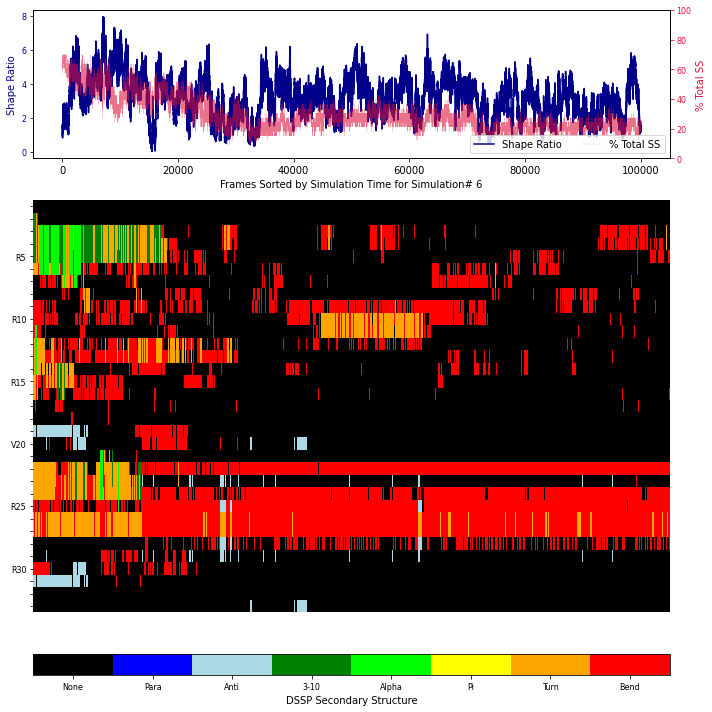

In [20]:
fig,axs=plt.subplots(ncols=1,nrows=3,figsize=(10,10),
                     gridspec_kw={'height_ratios':[1.8,5,0.25]})
#'width_ratios': [15],
sim=6
salmon_heatmap=salmon_secstruc[salmon_secstruc.sim==sim].copy()
ss=ss_propensity(salmon_secstruc[salmon_secstruc.sim==sim])
salmon_heatmap['Rg']=salmon_rg_ree[salmon_rg_ree.sim==sim].Rg.values
salmon_heatmap['Ree']=salmon_rg_ree[salmon_rg_ree.sim==sim].Ree.values
salmon_heatmap['ratio']=salmon_heatmap.Ree.values**2/salmon_heatmap.Rg.values**2
salmon_heatmap['total_ss']=ss.values
#salmon_heatmap=salmon_heatmap.sort_values(by=['Rg'],ascending=True)
ratio_line=axs[0].plot(salmon_heatmap.frames,salmon_heatmap.ratio, color='darkblue',linewidth=1.5,label='Shape Ratio')
#axs[0].legend(fontsize=10,loc='lower right')
axs[0].set_ylabel('Shape Ratio',color='darkblue',fontsize=10)
axs[0].tick_params(axis="y", colors="darkblue")
axs[0].tick_params(axis="x", bottom=True)
plt.setp(axs[0].get_yticklabels(), fontsize=8)
axs[0].set_xlabel('Frames Sorted by Simulation Time for Simulation# '+str(sim),
                   fontsize=10)
#axs[0].set_title('salmon Protamine: All Simulations Combined',
#                   fontsize=20)
ax=axs[0].twinx()
total_ss_line=ax.plot(salmon_heatmap.total_ss.values*100,color='crimson',alpha=0.6,
                      linewidth=0.2,label='% Total SS')
ax.set_ylabel('% Total SS', color='crimson',fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize=8)
ax.tick_params(axis="y", colors="crimson")
ax.set_ylim(0,100)
total_lines=ratio_line+total_ss_line
total_labs=[l.get_label() for l in total_lines]
ax.legend(total_lines,total_labs,fontsize=10,loc='lower right',ncol=2)
sequence='MPRRRRSSSRPVRRRRRPRVSRRRRRRGGRRRR'
sequence=[sequence[i-1]+str(i) for i in range(1,len(sequence)+1)]
sns.heatmap(salmon_heatmap.iloc[:,2:-4].T,ax=axs[1],
            xticklabels=False,yticklabels=True,
            cmap=ListedColormap(['black', 'blue','lightblue',
                                 'green','lime','yellow','orange','red']),
            cbar=False)
axs[1].set_yticklabels(sequence,fontsize=8)
plt.setp([y_label_seq for y_label_seq in axs[1].get_yticklabels() if y_label_seq not in axs[1].get_yticklabels()[4::5]],
         visible=False)

cmap = mpl.colors.ListedColormap(['black', 'blue','lightblue',
                                  'green','lime','yellow','orange','red'])
cmap.set_over('0.25')
cmap.set_under('0.75')

bounds = [0, 1, 2, 3, 4, 5,6,7, 8]
ticks=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cbar = mpl.colorbar.ColorbarBase(axs[2], cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                                ticks=ticks,
                                spacing='proportional',
                                orientation='horizontal')
cbar.set_ticklabels(['None','Para','Anti','3-10','Alpha','Pi','Turn','Bend'])
cbar.set_label('DSSP Secondary Structure',size=10)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs)
font_size=8
cbar.ax.tick_params(labelsize=font_size)
plt.setp(axs[2].get_yticklabels(), fontsize=8)
#axs[0,1].remove()
plt.tight_layout()
#plt.savefig('figures_for_publication/salmon_secstruc.png',dpi=400,bbox_inches='tight')


# Bull 

In [36]:
bull_rg=pd.read_csv("bull_Rg_master_out.csv")
bull_ree=pd.read_csv("bull_Ree_master_out.csv")
bull_rg_ree=pd.concat([bull_rg,bull_ree.iloc[:,2:]],axis=1)
bull_rg_ree['ratio']=bull_rg_ree.Ree.values**2/bull_rg_ree.Rg.values**2
del bull_rg, bull_ree
bull_secstruc = pd.read_csv("bull_master_secstruct.csv")

In [37]:
frame_counts=bull_secstruc.groupby('sim').Frames.max()
for simm in frame_counts.index:
    secstruc_bool=(bull_secstruc.sim==simm) & (bull_secstruc.Frames==frame_counts[simm]) 
    bull_secstruc=bull_secstruc[~secstruc_bool]
temp_secstruc=bull_secstruc.Secstruct.values
temp_secstruc=temp_secstruc.reshape((int(temp_secstruc.shape[0]/int(bull_secstruc.Residues.max()))),int(bull_secstruc.Residues.max()))
temp_secstruc=pd.DataFrame(data=temp_secstruc,columns=bull_secstruc.Residues.unique())
bull_secstruc=pd.concat([bull_rg_ree.iloc[:,:2],temp_secstruc],axis=1)
del temp_secstruc


In [38]:
bull_rg_ree=bull_rg_ree[bull_rg_ree.sim!=14]
bull_rg_ree=bull_rg_ree[bull_rg_ree.sim!=15]
bull_secstruc=bull_secstruc[bull_secstruc.sim!=14]
bull_secstruc=bull_secstruc[bull_secstruc.sim!=15]

In [13]:
# blank_df = pd.DataFrame()
# for sim in bull_rg_ree.sim.unique():
#     temp_df = bull_rg_ree[bull_rg_ree.sim==sim].iloc[-40000:,:]
#     blank_df = blank_df.append(temp_df)
# bull_rg_ree = blank_df.copy()
# del blank_df
# del temp_df
# blank_df = pd.DataFrame()
# for sim in bull_secstruc.sim.unique():
#     temp_df = bull_secstruc[bull_secstruc.sim==sim].iloc[-40000:,:]
#     blank_df = blank_df.append(temp_df)
# bull_secstruc = blank_df.copy()
# del blank_df, temp_df


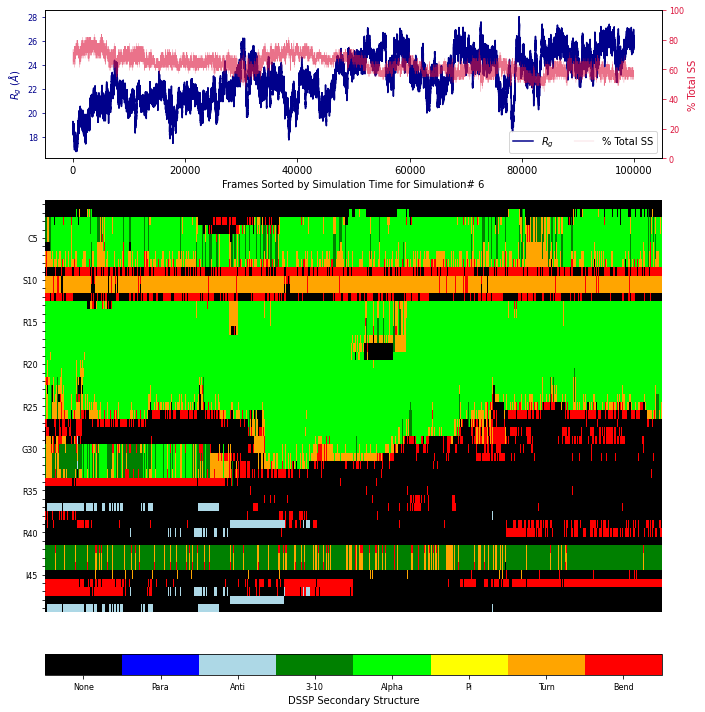

In [39]:
fig,axs=plt.subplots(ncols=1,nrows=3,figsize=(10,10),
                     gridspec_kw={'height_ratios':[1.8,5,0.25]})
#'width_ratios': [15],
sim=6
bull_heatmap=bull_secstruc[bull_secstruc.sim==sim].copy()
ss=ss_propensity(bull_secstruc[bull_secstruc.sim==sim])
bull_heatmap['Rg']=bull_rg_ree[bull_rg_ree.sim==sim].Rg.values
bull_heatmap['Ree']=bull_rg_ree[bull_rg_ree.sim==sim].Ree.values
bull_heatmap['ratio']=bull_heatmap.Ree.values**2/bull_heatmap.Rg.values**2
bull_heatmap['total_ss']=ss.values
#bull_heatmap=bull_heatmap.sort_values(by=['Rg'],ascending=True)
rg_line=axs[0].plot(bull_heatmap.Rg.values, color='darkblue',linewidth=1.5,label=r'$R_{g}$')
#axs[0].legend(fontsize=10,loc='lower right')
axs[0].set_ylabel(r'$R_{g}$'+' ('+r'$\AA$'+')',color='darkblue',fontsize=10)
axs[0].tick_params(axis="y", colors="darkblue")
axs[0].tick_params(axis="x", bottom=True, labelbottom=True)
plt.setp(axs[0].get_yticklabels(), fontsize=8)
axs[0].set_xlabel('Frames Sorted by Simulation Time for Simulation# '+str(sim),
                   fontsize=10)
#axs[0].set_title('bull Protamine: All Simulations Combined',
#                   fontsize=20)
ax=axs[0].twinx()
total_ss_line=ax.plot(bull_heatmap.total_ss.values*100,color='crimson',alpha=0.6,
                      linewidth=0.2,label='% Total SS')
ax.set_ylabel('% Total SS', color='crimson',fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize=8)
ax.tick_params(axis="y", colors="crimson")
ax.set_ylim(0,100)
total_lines=rg_line+total_ss_line
total_labs=[l.get_label() for l in total_lines]
ax.legend(total_lines,total_labs,fontsize=10,loc='lower right',ncol=2)
sequence='ARYRCCLTHSGSRCRRRRRRRCRRRRRRFGRRRRRRVCCRRYTVIRCRR'
sequence=[sequence[i-1]+str(i) for i in range(1,len(sequence)+1)]
sns.heatmap(bull_heatmap.iloc[:,2:-4].T,ax=axs[1],
            xticklabels=False,yticklabels=True,
            cmap=ListedColormap(['black', 'blue','lightblue',
                                 'green','lime','yellow','orange','red']),
            cbar=False)
axs[1].set_yticklabels(sequence,fontsize=8)
plt.setp([y_label_seq for y_label_seq in axs[1].get_yticklabels() if y_label_seq not in axs[1].get_yticklabels()[4::5]],
         visible=False)

cmap = mpl.colors.ListedColormap(['black', 'blue','lightblue',
                                  'green','lime','yellow','orange','red'])
cmap.set_over('0.25')
cmap.set_under('0.75')

bounds = [0, 1, 2, 3, 4, 5,6,7, 8]
ticks=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cbar = mpl.colorbar.ColorbarBase(axs[2], cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                                ticks=ticks,
                                spacing='proportional',
                                orientation='horizontal')
cbar.set_ticklabels(['None','Para','Anti','3-10','Alpha','Pi','Turn','Bend'])
cbar.set_label('DSSP Secondary Structure',size=10)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs)
font_size=8
cbar.ax.tick_params(labelsize=font_size)
plt.setp(axs[2].get_yticklabels(), fontsize=8)
#axs[0,1].remove()
plt.tight_layout()
#plt.savefig('figures_for_publication/bull_secstruc.png',dpi=400,bbox_inches='tight')


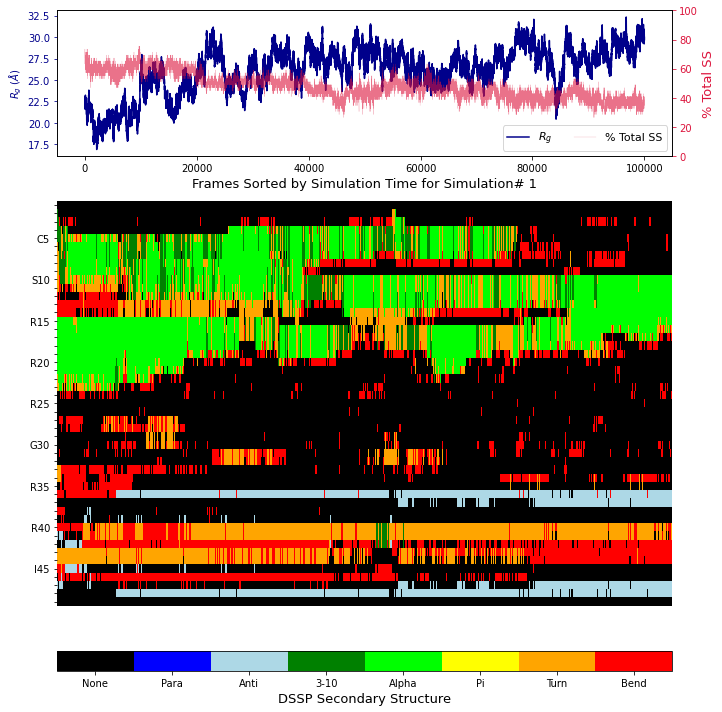

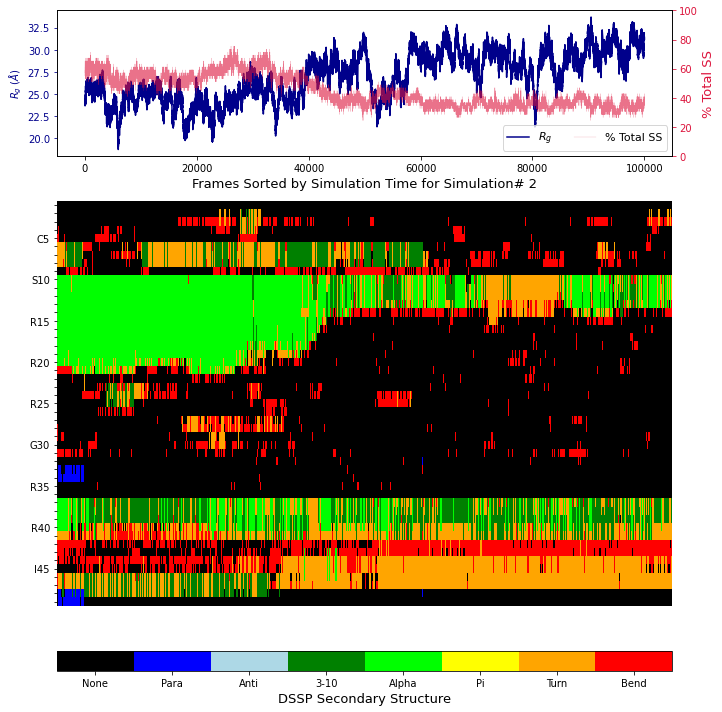

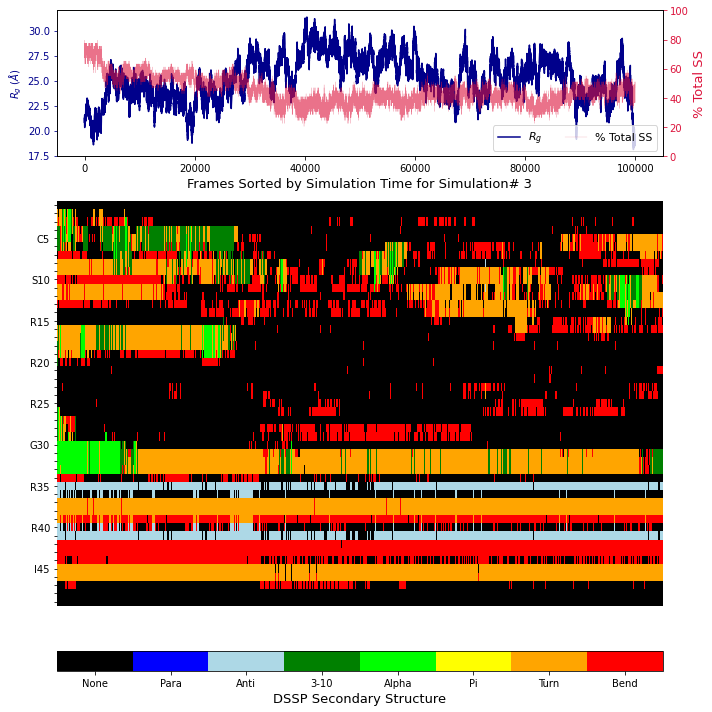

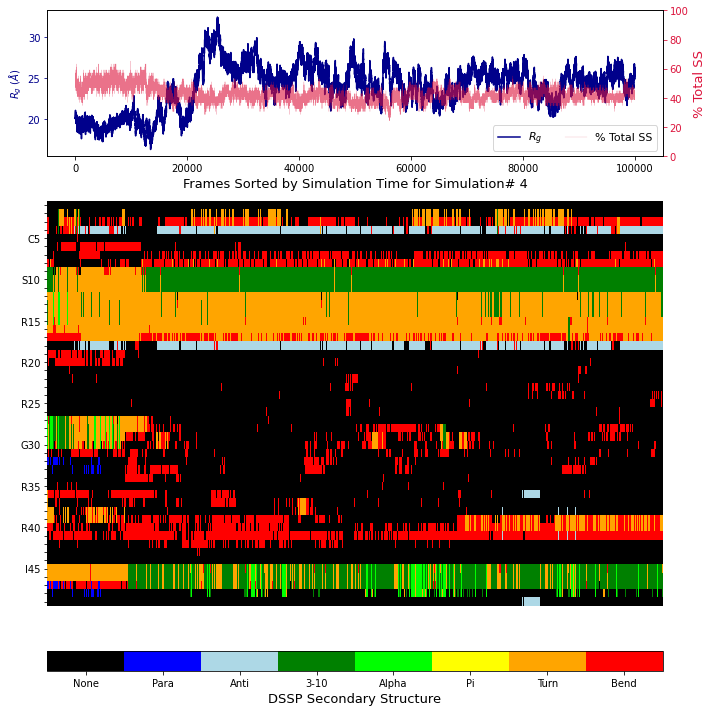

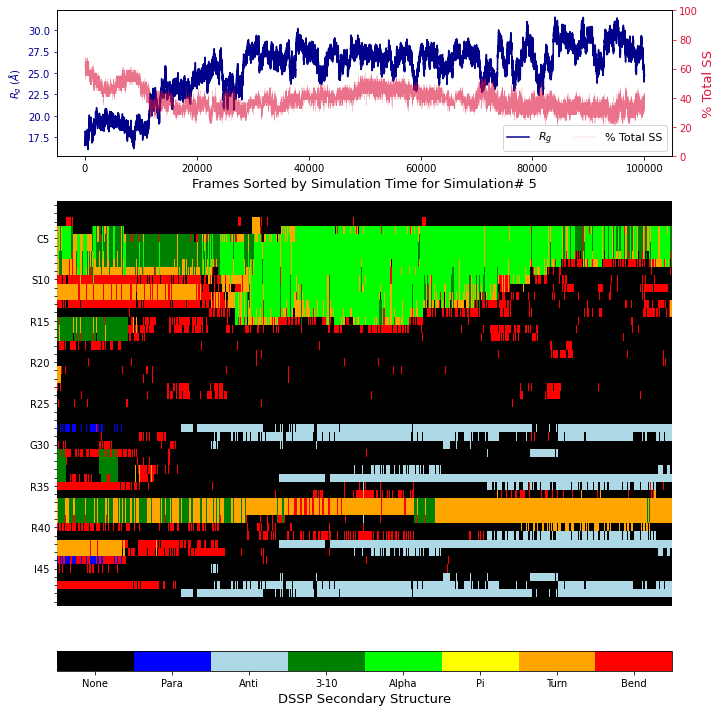

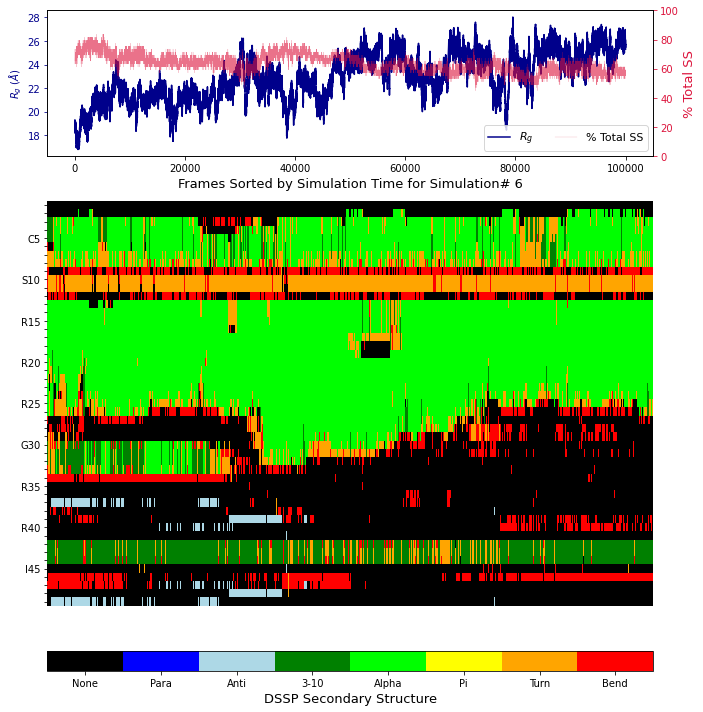

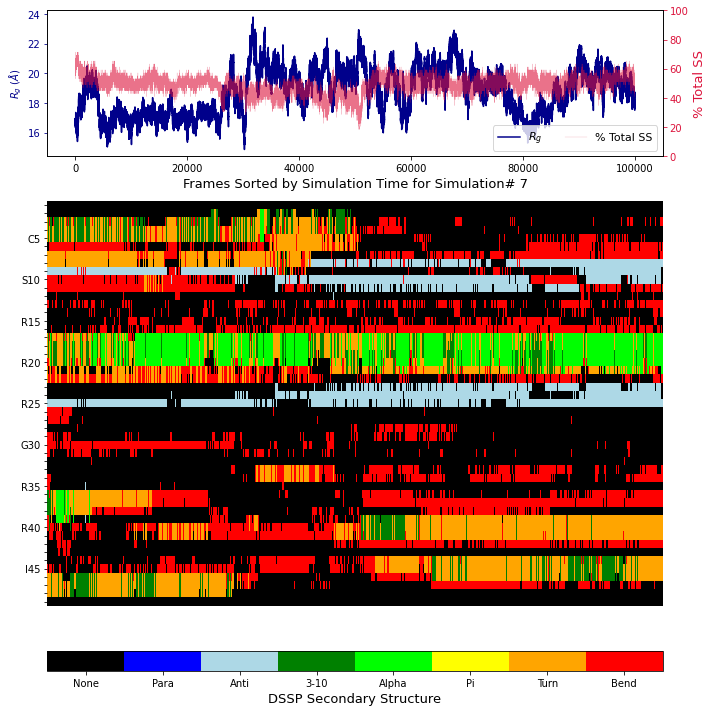

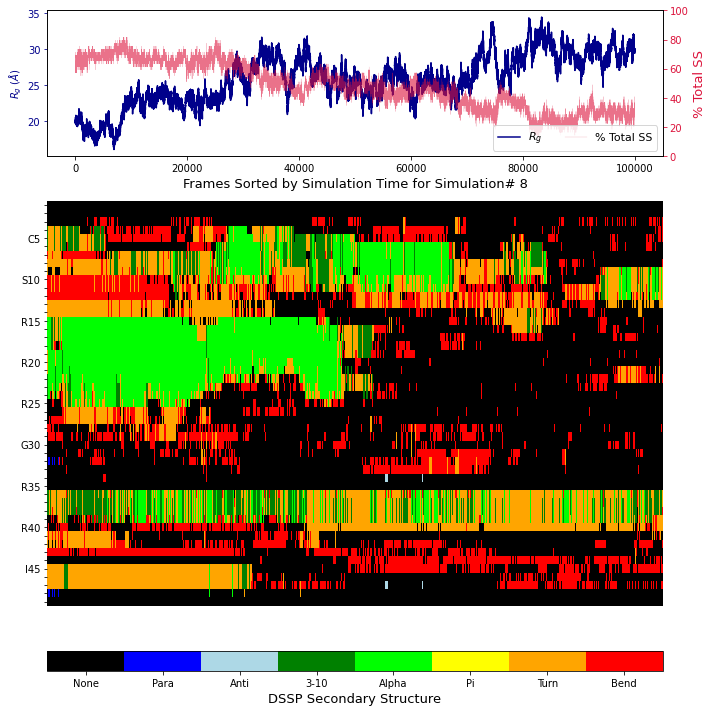

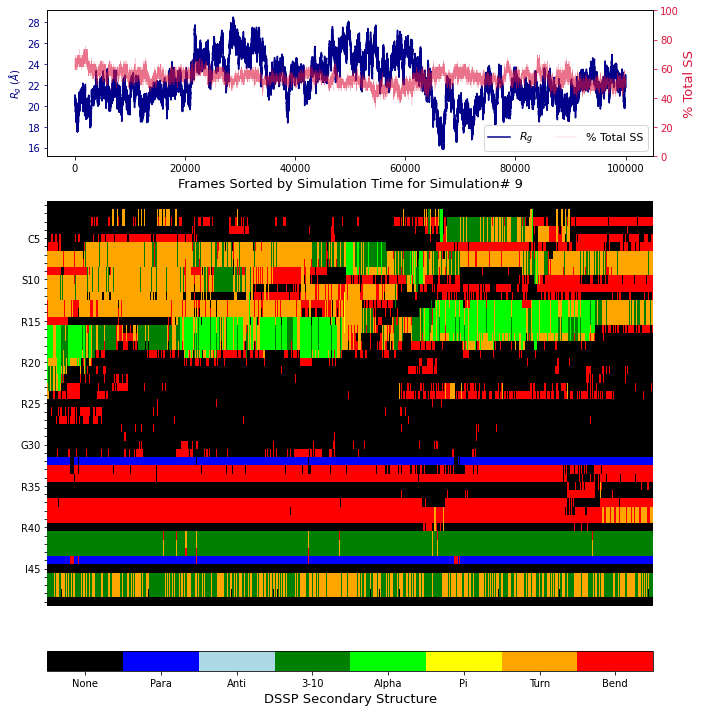

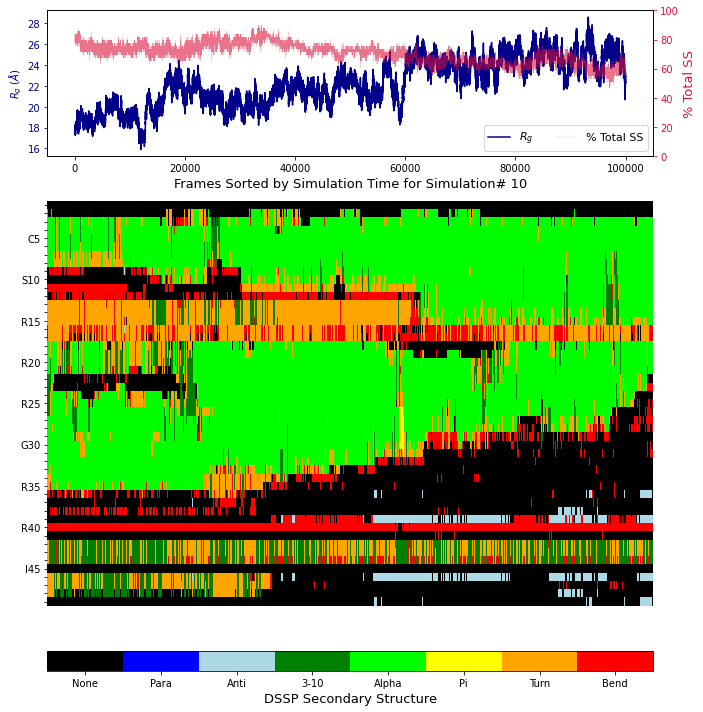

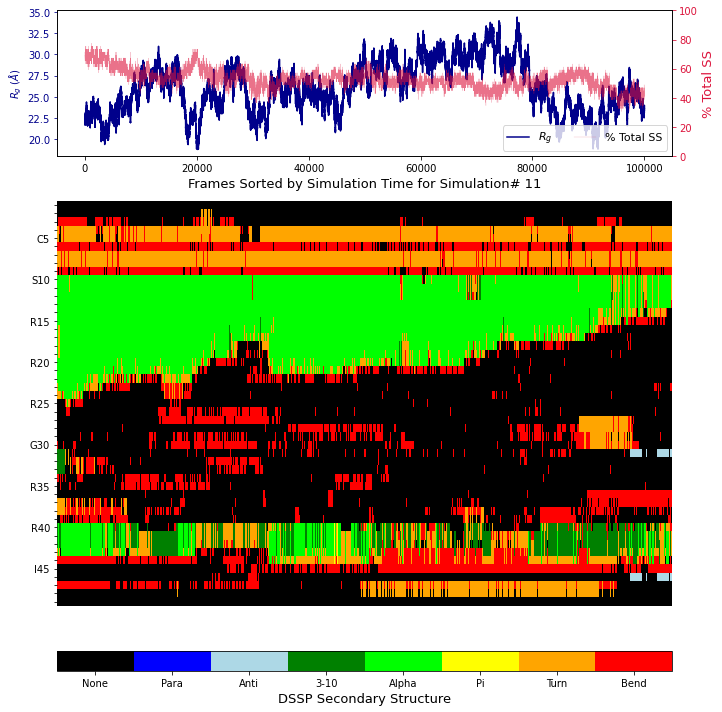

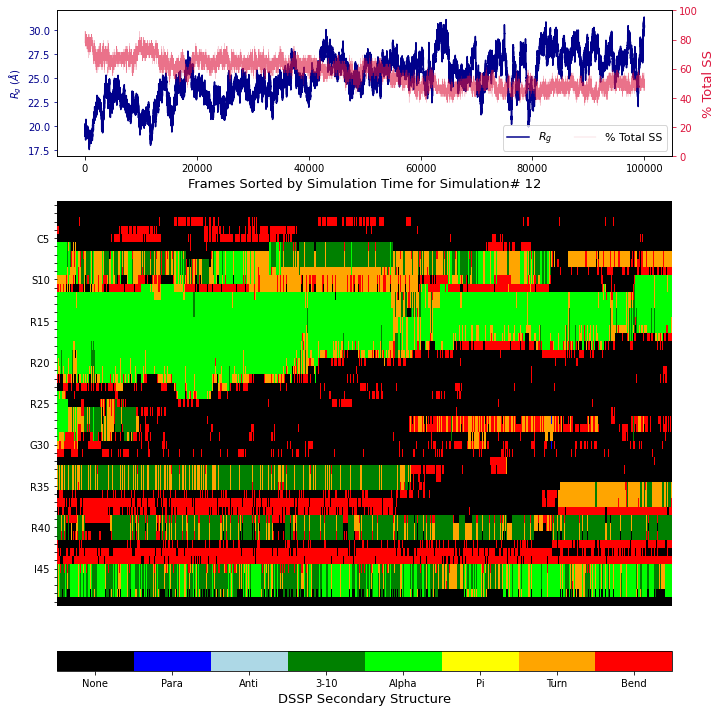

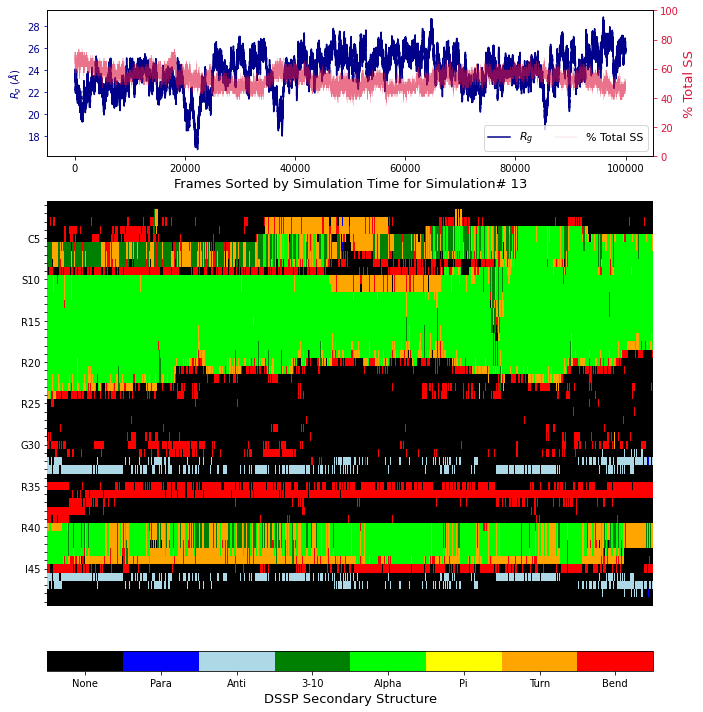

In [40]:
#'width_ratios': [15],
#make sure CORRECT number of sims
sims=[1,2,3,4,5,6,7,8,9,10,11,12,13]
for sim in sims:
    fig,axs=plt.subplots(ncols=1,nrows=3,figsize=(10,10),
                         gridspec_kw={'height_ratios':[1.8,5,0.25]})    
    bull_heatmap=bull_secstruc[bull_secstruc.sim==sim].copy()
    ss=ss_propensity(bull_secstruc[bull_secstruc.sim==sim])
    bull_heatmap['Rg']=bull_rg_ree[bull_rg_ree.sim==sim].Rg.values
    bull_heatmap['total_ss']=ss.values
    #bull_heatmap=bull_heatmap.sort_values(by=['Rg'],ascending=True)
    rg_line=axs[0].plot(bull_heatmap.frames,bull_heatmap.Rg, color='darkblue',linewidth=1.5,label=r'$R_{g}$')
    #axs[0].legend(fontsize=10,loc='lower right')
    axs[0].set_ylabel(r'$R_{g}$'+' ('+r'$\AA$'+')',color='darkblue')
    axs[0].tick_params(axis="y", colors="darkblue")
    axs[0].tick_params(axis="x", bottom=True, labelbottom=True,labelsize=10)
    plt.setp(axs[0].get_yticklabels(), fontsize=10)
    axs[0].set_xlabel('Frames Sorted by Simulation Time for Simulation# '+str(sim),
                       fontsize=13)

    #axs[0].set_title('Human bull Protamine: All Simulations Combined',
    #                   fontsize=20)
    ax=axs[0].twinx()
    total_ss_line=ax.plot(bull_heatmap.total_ss.values*100,color='crimson',alpha=0.6,
                          linewidth=0.2,label='% Total SS')
    ax.set_ylabel('% Total SS', color='crimson',fontsize=13)
    plt.setp(ax.get_yticklabels(), fontsize=8)
    ax.tick_params(axis="y", colors="crimson",labelsize=10)
    ax.set_ylim(0,100)
    total_lines=rg_line+total_ss_line
    total_labs=[l.get_label() for l in total_lines]
    ax.legend(total_lines,total_labs,fontsize=11,loc='lower right',ncol=2)
    sequence='ARYRCCLTHSGSRCRRRRRRRCRRRRRRFGRRRRRRVCCRRYTVIRCRR'
    sequence=[sequence[i-1]+str(i) for i in range(1,len(sequence)+1)]
    sns.heatmap(bull_heatmap.iloc[:,2:-2].T,ax=axs[1],
                xticklabels=False,yticklabels=True,
                cmap=ListedColormap(['black', 'blue','lightblue',
                                     'green','lime','yellow','orange','red']),
                cbar=False)
    axs[1].set_yticklabels(sequence,fontsize=10)
    plt.setp([y_label_seq for y_label_seq in axs[1].get_yticklabels() if y_label_seq not in axs[1].get_yticklabels()[4::5]],
             visible=False)

    cmap = mpl.colors.ListedColormap(['black', 'blue','lightblue',
                                      'green','lime','yellow','orange','red'])
    cmap.set_over('0.25')
    cmap.set_under('0.75')

    bounds = [0, 1, 2, 3, 4, 5,6,7, 8]
    ticks=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    cbar = mpl.colorbar.ColorbarBase(axs[2], cmap=cmap,
                                    norm=norm,
                                    boundaries=bounds,
                                    ticks=ticks,
                                    spacing='proportional',
                                    orientation='horizontal')
    cbar.set_ticklabels(['None','Para','Anti','3-10','Alpha','Pi','Turn','Bend'])
    cbar.set_label('DSSP Secondary Structure',size=13)
    ticklabs = cbar.ax.get_yticklabels()
    cbar.ax.set_yticklabels(ticklabs)
    font_size=10
    cbar.ax.tick_params(labelsize=font_size)
    plt.setp(axs[2].get_yticklabels(), fontsize=10)
    #axs[0,1].remove()
    plt.tight_layout()
    plt.savefig('manuscript_revision/bull_secstruc_sim'+str(sim)+'.png',dpi=400,bbox_inches='tight')


In [16]:
bull_secstruc

,frames,sim,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0
60000,60001,1,0.0,0.0,0.0,4.0,4.0,4.0,4.0,7.0,...,6.0,6.0,0.0,0.0,0.0,0.0,7.0,0.0,2.0,0.0
60001,60002,1,0.0,0.0,0.0,4.0,4.0,4.0,4.0,7.0,...,6.0,6.0,0.0,0.0,0.0,0.0,7.0,0.0,2.0,0.0
60002,60003,1,0.0,0.0,0.0,4.0,4.0,4.0,4.0,7.0,...,6.0,6.0,0.0,0.0,0.0,0.0,7.0,0.0,2.0,0.0
60003,60004,1,0.0,0.0,0.0,4.0,4.0,4.0,4.0,7.0,...,6.0,6.0,0.0,0.0,7.0,0.0,0.0,0.0,2.0,0.0
60004,60005,1,0.0,0.0,0.0,4.0,4.0,4.0,4.0,7.0,...,6.0,6.0,0.0,7.0,7.0,0.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299995,99996,13,0.0,0.0,0.0,0.0,6.0,6.0,4.0,4.0,...,6.0,6.0,6.0,0.0,0.0,7.0,0.0,2.0,2.0,0.0
1299996,99997,13,0.0,0.0,0.0,0.0,3.0,3.0,3.0,4.0,...,6.0,6.0,6.0,0.0,0.0,7.0,0.0,2.0,2.0,0.0
1299997,99998,13,0.0,0.0,0.0,0.0,3.0,3.0,3.0,4.0,...,6.0,6.0,6.0,0.0,0.0,7.0,0.0,2.0,2.0,0.0
1299998,99999,13,0.0,0.0,0.0,0.0,6.0,6.0,4.0,4.0,...,6.0,6.0,6.0,0.0,0.0,7.0,0.0,2.0,2.0,0.0
